In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import serial
import random
import time
import nidaqmx
from nidaqmx.constants import TerminalConfiguration
from nidaqmx.constants import LineGrouping
from nidaqmx.constants import Edge
from nidaqmx.constants import AcquisitionType
from nidaqmx.stream_readers import (
    AnalogSingleChannelReader, AnalogMultiChannelReader)
import customTime
import online_sac_detect_module

## Plot eye position data offline 

In [2]:
eyepos=pd.read_csv('.\logFiles\eyeposData_18_3_S01_S2_T0089_ecc_0.23_spacing_100_SOA_0.050_valid_logFile_02_16_2022_02_14_31.csv',header=0)

In [3]:
xpos=eyepos['xpos']
xpos_normed=(xpos-np.min(xpos))/(np.max(xpos)-np.min(xpos))
sacc_onset=times[np.where(eyepos['sac_detected']==1)]
plt.plot(times,xpos_normed,'.-',label='Horizontal')
ax=[plt.axvline(x=anx,ymin=0,ymax=1,color='k',alpha=0.1,label="Saccade detected" if anx==sacc_onset[0] else "") for anx in sacc_onset]
plt.xlabel("Time (sec)",size=12)
plt.ylabel("Normalized pixel voltage",size=12)
plt.legend()

NameError: name 'times' is not defined

In [90]:
os.chdir("D:\\KSP\\Study\\Houston\\Projects\\TSLOExperiments\\tslo_core\\External_display\logFiles")

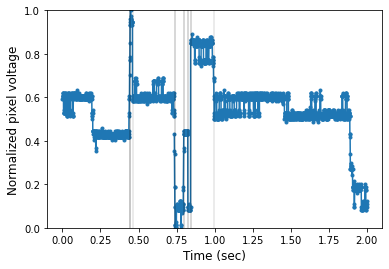

In [102]:
xpos=eyepos['xpos']
xpos_normed=(xpos-np.min(xpos))/(np.max(xpos)-np.min(xpos))
stepSize=140
timeSteps=np.arange(0,len(eyepos),stepSize)
counter=1
plt.figure(facecolor=(1, 1, 1))
for astep in timeSteps:
    
    temp_eyepos=eyepos.iloc[astep:astep+stepSize,:]
    temp_xpos=xpos_normed[astep:astep+stepSize]
    temp_times=times[astep:astep+stepSize]
    sacc_onset=temp_times[np.where(temp_eyepos['sac_detected']==1)]
    plt.plot(temp_times,temp_xpos,'.-',label='Horizontal',color='C0')
    ax=[plt.axvline(x=anx,ymin=0,ymax=1,color='k',alpha=0.1,label="Saccade detected" if anx==sacc_onset[0] else "") for anx in sacc_onset]
    
    plt.xlabel("Time (sec)",size=12)
    plt.ylabel("Normalized pixel voltage",size=12)
    plt.ylim(0,1)
    plt.savefig("eyetrace_%d.png"%(counter),dpi=300,bbox_inches='tight')
    counter+=1

## Reading input from A-to-D card

In [100]:
num_samples=2**20
xpos_list=np.zeros(num_samples)
ypos_list=np.zeros(num_samples)
timeStamp_list=np.zeros(num_samples)
array_idx=0
maxTime=10000
with nidaqmx.Task() as task:
    # We setup the ADC card using the nidaqmx library
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0",terminal_config=TerminalConfiguration.RSE)
    task.timing.cfg_samp_clk_timing(1000,"",sample_mode=AcquisitionType.HW_TIMED_SINGLE_POINT,samps_per_chan=1)
    startTime=customTime.millis()
    while customTime.millis()-startTime<=maxTime:
            # We would read in the x position from the TSLO
            # Also add time stamp\
#             try: # to function smoothly when there are no x positions to be read
            pre_read_time=customTime.millis()
            xpos_raw= task.read(number_of_samples_per_channel=1)
            post_read_time=customTime.millis()-pre_read_time
#             except:
#                 continue
            
            ypos=0 # generate random samples for now

            pythonReadTime=customTime.millis()
            #Add to corresponding arrays
            timeStamp_list[array_idx]=pythonReadTime
            xpos_list[array_idx]=xpos_raw[0]
            ypos_list[array_idx]=ypos
            array_idx+=1

eyepos_df=pd.DataFrame(np.column_stack((timeStamp_list,xpos_list,ypos_list)),columns=['time','xpos','ypos'])
eyepos_df['time']=eyepos_df['time']-eyepos_df['time'][0]


In [246]:
num_samples=2**16
xpos_list=np.zeros(num_samples)
ypos_list=np.zeros(num_samples)
timeStamp_list=np.zeros(num_samples)
detected_list=np.zeros(num_samples)
stimTimes=np.zeros(num_samples)
# Main set of parameters for the saccade detection method
vel_thresh=18
num_samples_above_thresh=3

# 1. saccade detection options
thres_fac = int(vel_thresh) # threshold factor, or lambda
above_thres_needed = int(num_samples_above_thresh) # how many samples above threshold do we need?
restrict_dir_min = int(0) # direction restriction.
restrict_dir_max = int(0)
samp_rate_now = int(1000) # resampling frequency
anchor_vel_thres = thres_fac
print_results = 0 # set to 0, if you don't want any feedback from stdout
start_sample=30

## 2. import the module and set parameters
detect_this = online_sac_detect_module.online_sac_detect()
detect_this.set_parameters(thres_fac, above_thres_needed, 
                       restrict_dir_min, restrict_dir_max, 
                       samp_rate_now, anchor_vel_thres, print_results)
detect_this.return_data() # returns current data (should be empty after loading)
detect_this.get_parameters() # returns current parameters
detect_this.reset_data() # resets/clears all existing data
array_idx=0
resetCounter=0
conn_status=1
maxTime=20000

## Main Loop

with nidaqmx.Task() as task:
    # We setup the ADC card using the nidaqmx library
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0",terminal_config=TerminalConfiguration.RSE)
    task.timing.cfg_samp_clk_timing(1000,"",sample_mode=AcquisitionType.HW_TIMED_SINGLE_POINT,samps_per_chan=1)
    startTime=customTime.millis()
    while customTime.millis()-startTime<=maxTime:
        # We would read in the x position from the TSLO
        # Also add time stamp
        xpos_raw= task.read(number_of_samples_per_channel=1)
        # we scale it based on volts per degree setting on ICANDI
        volts_per_deg=0.8
        xpos_deg= xpos_raw[0]/volts_per_deg
        pix_per_deg=(512/4.75)
        xpos_pix=xpos_deg*pix_per_deg

        ypos=random.uniform(0.2, 0.21) # set an arbitary value for now
        ypos_pix=ypos*pix_per_deg
        pythonReadTime=customTime.millis()-startTime
        #Add to corresponding arrays
        # Since we know the samples are coming in at a regular rate 
        # We give it the array idx
        timeStamp_list[array_idx]=array_idx
        xpos_list[array_idx]=xpos_pix
        ypos_list[array_idx]=ypos_pix

        ### 4. Add new set of samples to data
        # add new sample coming in
        if array_idx<start_sample:
            array_idx+=1
            resetCounter+=1
            continue
        elif array_idx==start_sample:
            detect_this.add_data(xpos_list[range(1, array_idx)], 
                  ypos_list[range(1, array_idx)], 
                  timeStamp_list[range(1, array_idx)])
        else:
            detect_this.add_data(xpos_list[array_idx], 
                            ypos_list[array_idx], 
                            timeStamp_list[array_idx])

        #we reset the counter and the sitting in add data after 
        # certain number of samples
        resetSampleIdx=500
        counterWindow=20
        if resetCounter>resetSampleIdx:
            #reset data
            detect_this.reset_data()
            # add some data from earlier
            detect_this.add_data(xpos_list[(array_idx-counterWindow):array_idx],
                                ypos_list[(array_idx-counterWindow):array_idx],
                                timeStamp_list[(array_idx-counterWindow):array_idx])
            #reset counter
            resetCounter=0
        ### 5. Run detection method
        res_here, run_time_here = detect_this.run_detection() 
        # create a variable that tells whether or not there was a saccade
        sacc_status = res_here.sac_detected
        if sacc_status==np.nan:
            sacc_status=0
        #do something when we find a saccade
        detected_list[array_idx]=sacc_status
        # we then increment the array idx
        array_idx+=1
        resetCounter+=1 

        # we reset arrat idx after a certain value
        if array_idx>(num_samples-5):
            array_idx=0

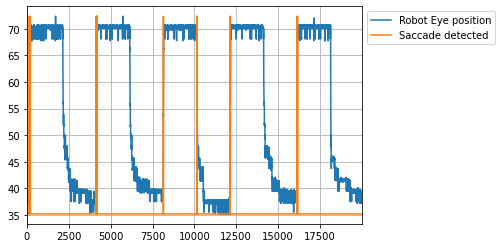

In [247]:
# plt.figure(figsize=(20,10))
plt.plot(xpos_list[0:array_idx],label='Robot Eye position')
detected_list_new=np.array(detected_list)
detected_list_new=np.where(detected_list_new==1,np.max(xpos_list),np.min(xpos_list[0:array_idx])) # Always a zero at the end
plt.plot(detected_list_new,label='Saccade detected')
plt.xlim(0,array_idx)
#plt.ylim(50,110)
plt.legend(bbox_to_anchor=(1,1))
plt.grid(True)

In [ ]:
diff=np.diff(eyepos_df['time'][0:array_idx])
np.mean(diff)

In [ ]:
eyepos_df.to_csv('.\OnlineSaccadeDetection\dummy_data.csv')

In [ ]:
downSampledData=eyepos_df.iloc[::2,:]
downSampledDataTruncated=downSampledData.iloc[900:1200,:]
plt.plot(downSampledDataTruncated['xpos'])

In [ ]:
downSampledDataTruncated.to_csv('.\OnlineSaccadeDetection\eyepos_rubbereyeRawDownsampledTruncated.csv')


## Realtime Saccade detection

In [ ]:
import online_sac_detect_module

In [ ]:
def read_bits (timeStamp_list,xpos_list,ypos_list,detected_list,times,ser,start_sample):
    while ser.in_waiting:
        read_byte = ser.readline()
        global counter
        global resetCounter
        try:
            read_byte=read_byte.decode("utf-8")
        except UnicodeDecodeError:
            read_byte=read_byte.decode("latin-1")
        read_byte=read_byte.split() # to get the values from the string
        if len(read_byte)==3: 
            # Sometimes empty byte messages can come through serial port
            # we use try and catch here for stability purposes
            ###2. Read eye position data
            try:
                timeStamp_list[counter]=int(read_byte[0])
                xpos_list[counter]=int(read_byte[1])
                ypos_list[counter]=random.randint(300,305)
#                    ypos_list[counter]=int(read_byte[2])
            except ValueError:
                print('ValueError')
                continue
            ### 4. Add new set of samples to data
            # add new sample coming in
            if counter<start_sample:
                counter+=1
                resetCounter+=1
                continue
            elif counter==start_sample:
                detect_this.add_data(xpos_list[range(1, counter)], 
                      ypos_list[range(1, counter)], 
                      timeStamp_list[range(1, counter)])
            else:
                detect_this.add_data(xpos_list[counter],
                                    ypos_list[counter],
                                    timeStamp_list[counter])
            
            #we reset the counter and the sitting in add data after 
            # certain number of samples
            resetSampleIdx=500
            counterWindow=20
            if resetCounter>resetSampleIdx:
                #reset data
                detect_this.reset_data()
                # add some data from earlier
                detect_this.add_data(xpos_list[(counter-counterWindow):counter],
                                    ypos_list[(counter-counterWindow):counter],
                                    timeStamp_list[(counter-counterWindow):counter])
                #reset counter
                resetCounter=0
               
            ### 5. Run detection method
            try:
                timer=time.time()
                res_here, run_time_here = detect_this.run_detection() 
                times[counter]=time.time()-timer
                # create a variable that tells whether or not there was a saccade
                sacc_status = res_here.sac_detected
                if sacc_status==np.nan:
                    sacc_status=0
                #do something when we find a saccade
                detected_list[counter]=(sacc_status)
            except OSError as error:
                 print(error )
#                 break
            # we then increment counter
            counter+=1
            resetCounter+=1
            break
        else:
            break

In [ ]:
## 1. set the parameters of interest 
# saccade detection options
thres_fac = int(20) # threshold factor, or lambda
above_thres_needed = int(4) # how many samples above threshold do we need?
restrict_dir_min = int(0) # direction restriction.
restrict_dir_max = int(0)
samp_rate_now = int(500) # resampling frequency
anchor_vel_thres = thres_fac
print_results = 0 # set to 0, if you don't want any feedback from stdout
start_sample=30

## 3. import the module and set parameters
detect_this = online_sac_detect_module.online_sac_detect()
detect_this.set_parameters(thres_fac, above_thres_needed, 
                           restrict_dir_min, restrict_dir_max, 
                           samp_rate_now, anchor_vel_thres, print_results)
detect_this.return_data() # returns current data (should be empty after loading)
detect_this.get_parameters() # returns current parameters

ser=serial.Serial("COM3",baudrate=115200,bytesize=serial.EIGHTBITS,timeout=None)
time.sleep(1)
ser.isOpen()
numSamples=15000
timeStamp_list=np.zeros(numSamples*4)
xpos_list=np.zeros(numSamples*4)
ypos_list=np.zeros(numSamples*4)
detected_list=np.zeros(numSamples*4)
times=np.zeros(numSamples*4)
counter=0
resetCounter=0

ser.reset_input_buffer()
startTime=time.time()
while counter<numSamples:
    read_bits(timeStamp_list,xpos_list,ypos_list,detected_list,times,ser,start_sample)

ser.close()
#time the program
endTime=time.time()-startTime
#save output
eyeposSignal=np.column_stack((timeStamp_list,xpos_list,ypos_list,detected_list))
eyeposDF=pd.DataFrame(eyeposSignal)
eyeposDF.columns=['time','xpos','ypos','sac_detected']

# play sound to indicate recording has finished
audioPath='C:\\projects\\tslo_core\\External_display\\breep.wav'
playsound(audioPath, block=True)
#print output
print(endTime)

In [ ]:
plt.plot(timeStamp_list[0:numSamples])

In [ ]:
plt.plot(times[0:numSamples],'.')

In [ ]:
num=np.sum(times)
print('%f' % num)

In [ ]:
plt.figure(figsize=(13,6))
eyeposDF['sac_rescale']=np.where(eyeposDF['sac_detected']==1,1000,0)
eyeposDF['xpos'].plot(label='X position')
eyeposDF['sac_rescale'].plot(alpha=0.2,label='Saccade detected',color='k')
plt.xlim(5,15000)
plt.ylim(0,1000)
plt.xlabel('Index position',size=12)
plt.ylabel('Eye position (pix)',size=12)
plt.legend()

In [ ]:
eyeposDF

In [ ]:
# Remove eye pos file if it already exists
try:
    os.remove('.\OnlineSaccadeDetection\eyepos_humaneye_fixate.csv')
except FileNotFoundError:
    print('File not there')
          
eyeposDF.to_csv('.\\OnlineSaccadeDetection\\eyepos_humaneye_fixate.csv')


In [ ]:
sac_data=pd.read_csv('logFiles/eyeposData_03_18_2021_04_53_48.csv',header=0)

In [ ]:
plt.figure(figsize=(15,5))
sac_data['sac_rescale']=np.where(sac_data['sac_detected']==1,1000,0)
sac_data['xpos'].plot(label='X position')
sac_data['sac_rescale'].plot(alpha=0.2,label='Saccade detected',color='k')
#plt.xlim(35000,40000)
#plt.ylim(0,1000)
plt.xlabel('Index position',size=12)
plt.ylabel('Eye position (pix)',size=12)
plt.legend()

In [ ]:
sac_data['time'].plot()

## Sending digital output messages

In [4]:
import nidaqmx

In [13]:
# Sends test message to server machine via parallel port

with nidaqmx.Task() as task:
    task.do_channels.add_do_chan("Dev1/port0/line2")
    counter=0
    while True:
        if counter%2==0:
            task.write(True)
        else:
            task.write(False)
        time.sleep(5)
        counter+=1

IndentationError: unexpected indent (<ipython-input-13-c476595ab26e>, line 6)

In [11]:
# Sends test message to TSLO machine via teensy and this shows up on the retinal video
with nidaqmx.Task() as task:
    task.do_channels.add_do_chan("Dev1/port0/line0")
    counter=0
    while True:
        if counter%2==0:
            task.write(True)
        else:
            task.write(False)
        time.sleep(5)
        counter+=1

KeyboardInterrupt: 